In [39]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,  r2_score
from sklearn.preprocessing import RobustScaler
import seaborn as sns

In [40]:
%matplotlib inline

In [41]:
df = pd.read_csv("/kaggle/input/battery-remaining-useful-life-rul/Battery_RUL.csv")
df.head()


,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
0,1.0,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,10777.82,1112
1,2.0,7408.64,1172.512500,4.246,3.220,5508.992,6762.02,10500.35,1111
2,3.0,7393.76,1112.992000,4.249,3.224,5508.993,6762.02,10420.38,1110
3,4.0,7385.50,1080.320667,4.250,3.225,5502.016,6762.02,10322.81,1109
4,6.0,65022.75,29813.487000,4.290,3.398,5480.992,53213.54,56699.65,1107


In [42]:
# This is time series data without and id column for the battery, but we can use the fact that
# cycle index is reset to 1 for each battery to generate a device id 
df["split"] = df["Cycle_Index"] == 1.0
df["device_id"] = df["split"].cumsum()

In [43]:
# We probably want to include the full life cycle of some devices into the train dataset to be able
# to learn to predict remaing useful life. Shuffle which devices are in the train and test.
devices = df["device_id"].unique()
np.random.shuffle(devices)

num_train_devices = 10
train_devices = devices[:num_train_devices]
test_devices = devices[num_train_devices:]

train = df[df['device_id'].isin(train_devices)]
test = df[df['device_id'].isin(test_devices)]

<Axes: >

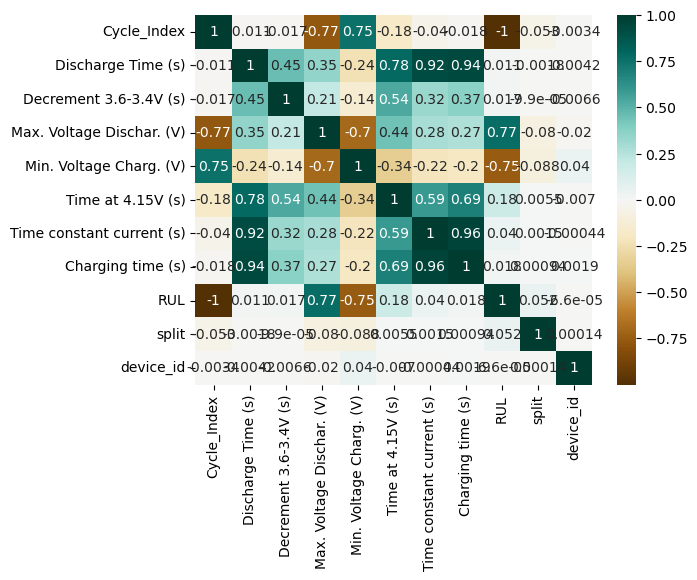

In [44]:
# Check variable correlations
# 1. Look for features that appear predictive (are correlated to) the target variable -> Good candidates for training a model
# 2. Look for features that are highly correlated -> should remove highly correlated features to avoid tripping models that expect independent features
sns.heatmap(train.corr(method='pearson'), cmap='BrBG', annot=True)


In [45]:
# 'Max. Voltage Dischar. (V)' has a pretty strong positive correlation with RUL
# 'Min. Voltage Charg. (V)' has a pretty strong negative correlation with RUL
# These look useful. Based on correlations, no other features look that useful.
# Lets plot all features against RUL to check what the distributions look like.

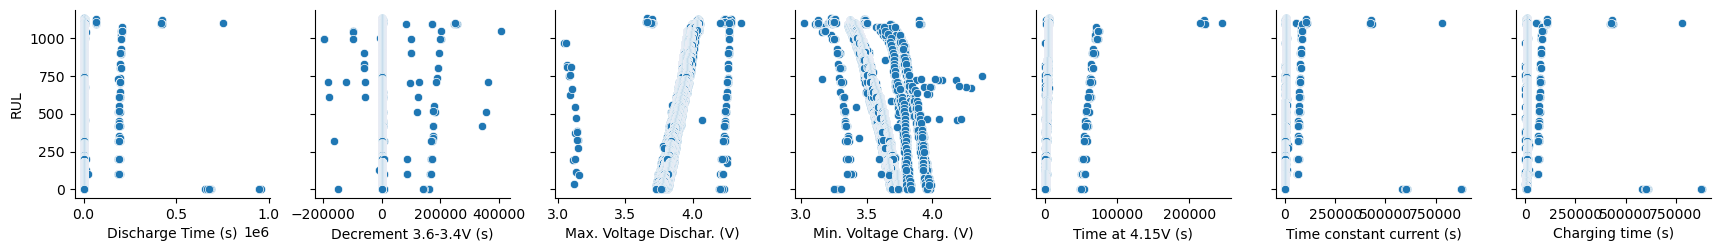

In [46]:
sns.pairplot(train,
             x_vars=['Discharge Time (s)', 'Decrement 3.6-3.4V (s)',
                     'Max. Voltage Dischar. (V)', 'Min. Voltage Charg. (V)',
                     'Time at 4.15V (s)', 'Time constant current (s)', 'Charging time (s)'],
             y_vars=['RUL'])


In [47]:
# 'Max. Voltage Dischar. (V)' looks pretty linear with RUL, but there are outliers.
# Same story with 'Min. Voltage Charg. (V)' looks linear with RUL (negative correlation) but with outliers.

# Based on this, a linear model could work ok but need to do something about the outliers.
# Could use a RobustScaler which takes outliers into consideration.
# We could also try a Random Forest which is robust to outliers.

<Axes: xlabel='Max. Voltage Dischar. (V)'>

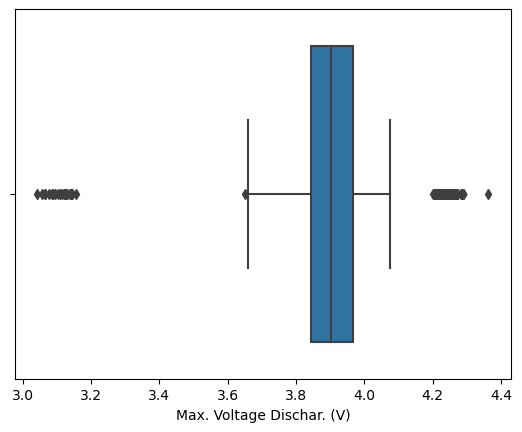

In [48]:
sns.boxplot(x='Max. Voltage Dischar. (V)', data=train)


<Axes: xlabel='Min. Voltage Charg. (V)'>

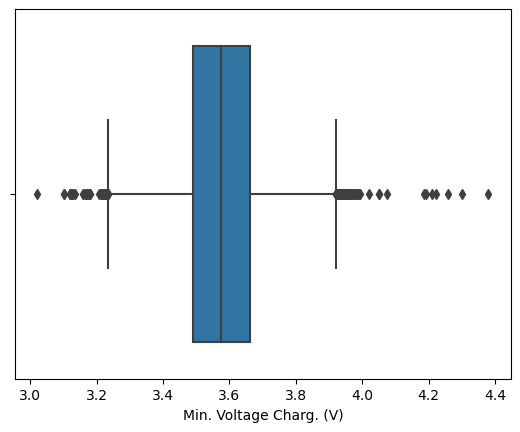

In [49]:
sns.boxplot(x='Min. Voltage Charg. (V)', data=train)


In [50]:
# keep only the relevant columns
features = ['Min. Voltage Charg. (V)', 'Max. Voltage Dischar. (V)']
label = ['RUL']

# split into train and test features X and labels y
X_train = train[features]
y_train = train[label]
X_test = test[features]
y_test = test[label]

In [51]:
# Ok, lets compare the perfomance of some models.
# As performance metrics we can use the Root Mean Squared Error (RMSE) and the R2 score.
def calculate_metrics(y, preds):
    r2 = r2_score(y, preds)
    rmse = mean_squared_error(y, preds, squared=False)

    return r2, rmse

In [52]:
# We start by scaling the features with RobustScaler
robust_scaler = RobustScaler()
robust_scaler.fit(X_train)

X_train = robust_scaler.transform(X_train)
X_test = robust_scaler.transform(X_test)

In [53]:
# Lets start with a simple linear model as a baseline, and we can try to improve upon it later
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

preds = linear_model.predict(X_test)
r2, rmse = calculate_metrics(y_test, preds)
print(f"Linear model: R2: {r2}, RMSE: {rmse}")


Linear model: R2: 0.7288497525577406, RMSE: 167.63495272626508


In [54]:
# Can we improve on this with a Random Forest?
random_forest_model = RandomForestRegressor()
random_forest_model.fit(X_train, y_train.to_numpy().ravel())

preds = random_forest_model.predict(X_test)
r2, rmse = calculate_metrics(y_test, preds)
print(f"Linear model: R2: {r2}, RMSE: {rmse}")


Linear model: R2: 0.9694071818377179, RMSE: 56.307898156669935


In [55]:
# We can see that for this test, random forest was clearly better than linear regression